# Tensorflow cross-domain integrated gradients demo

We demostrate the Tensorflow Cross-domain IG library on a Convolutional Neural Network (CNN) for a synthetic timeseries dataset. 

We consider a two-channel time-domain input (mixed signal), generated as the mixture of two sinusoidal inputs (source signal). The goal is to classify the frequency of the source signal. We train a CNN to classify the mixed inputs and then deploy Cross-domain IG to evaluate which input components affect the classification output.

In [11]:
import random
import numpy as np
import tensorflow as tf
from cross_domain_saliency_maps.tensorflow_ig.cross_domain_integrated_gradients import FourierIG
from cross_domain_saliency_maps.tensorflow_ig.cross_domain_integrated_gradients import ICAIG
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.decomposition import FastICA

In [12]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Input generation

We generate signals as the sum of two oscillating source signals with frequencies at $f_1 Hz$ and $f_2 Hz$. Each source signal window is sampled from the single-oscillation time-signal:
$$x_i(t) = cos(2 \pi f_i + \phi)$$

We sample windows of $8$ seconds at a sampling frequency $f_s = 32 Hz$, generating $256$ time-points for each sample, $\boldsymbol{x} \in \mathbb{R}^{256}$. The source vectors $\boldsymbol{x}$ are then linearly mixed using the ```mixing_matrix``` (A) to form the mixed inputs $\boldsymbol{x}_{mixed}$:
$$ X_{mixed} = A \cdot X$$
where $X = [\boldsymbol{x_1}, \boldsymbol{x_2}] \in \mathbb{R}^{2 \times 256}$ and similarly for $X_{mixed}$.

We generate windows of two classes, where only $f_1$ is informative of the class:
1. **Class 1:** $f_1 \sim \mathcal{N}(1.0, 0.1)$, $f_2 \sim \mathcal{N}(4.0, 0.1)$
1. **Class 2:** $f_1 \sim \mathcal{N}(2.5.0, 0.1)$, $f_2 \sim \mathcal{N}(4.0, 0.1)$

We generate $10^4$ windows for training and testing.

In [13]:
fs = 32.0 #Hz
simulation_time = 8.0 #seconds

n_samples_per_class = 10_000

In [14]:
def generate_signals(t, f1, f2, f_std, mixing_matrix, n_samples_per_class):
    phi = np.random.uniform(0, 2 * np.pi, size = n_samples_per_class)
    freqs = np.random.normal(loc = f1, scale = f_std, size = n_samples_per_class)
    x1 = np.cos(2 * np.pi * freqs[..., None] * t[None, ...] + phi[..., None])

    phi = np.random.uniform(0, 2 * np.pi, size = n_samples_per_class)
    freqs = np.random.normal(loc = f2, scale = f_std, size = n_samples_per_class)
    x2 = np.cos(2 * np.pi * freqs[..., None] * t[None, ...] + phi[..., None])

    X1 = mixing_matrix[0, 0] * x1 + mixing_matrix[0, 1] * x2
    X2 = mixing_matrix[1, 0] * x1 + mixing_matrix[1, 1] * x2

    X1 = X1 - X1.mean(axis = -1)[..., None]
    X2 = X2 - X2.mean(axis = -1)[..., None]

    x_mixed = np.stack([X1, X2], axis = -1)
    x_source = np.stack([x1, x2], axis = -1)

    return x_mixed, x_source

In [15]:
N_timepoints = int(fs * simulation_time)
t = np.linspace(0, simulation_time, N_timepoints)

mixing_matrix = np.array([[0.5, 0.75], 
                          [0.9, 0.1]])

# Generate training samples

X1, X1_unmixed = generate_signals(t, f1 = 1.0, f2 = 4.0, f_std = 0.1, mixing_matrix = mixing_matrix, n_samples_per_class = n_samples_per_class)
y1 = np.zeros((n_samples_per_class))

X2, _ = generate_signals(t, f1 = 2.5, f2 = 4.0, f_std = 0.1, mixing_matrix = mixing_matrix, n_samples_per_class = n_samples_per_class)
y2 = np.ones((n_samples_per_class))

X_train = np.concatenate([X1, X2], axis = 0)
y_train = np.concatenate([y1, y2], axis = 0)

X_train, y_train = shuffle(X_train, y_train)

# Generate test samples

X1, _ = generate_signals(t, f1 = 1.0, f2 = 4.0, f_std = 0.1, mixing_matrix = mixing_matrix, n_samples_per_class = n_samples_per_class)
y1 = np.zeros((n_samples_per_class))

X2, _ = generate_signals(t, f1 = 2.5, f2 = 4.0, f_std = 0.1, mixing_matrix = mixing_matrix, n_samples_per_class = n_samples_per_class)
y2 = np.ones((n_samples_per_class))

X_test = np.concatenate([X1, X2], axis = 0)
y_test = np.concatenate([y1, y2], axis = 0)

X_test, y_test = shuffle(X_test, y_test)

We plot the first two seconds of an example input window:
- **Left panel.** We plot the original unmixed channels in which the slower (green) oscillation bears the class information. The fast signal oscillates always at the same $4.0 Hz$ frequency regardless of the sample class.
- **Right panel.** We plot the input mixed channels in which the class information is mixed in both input channels.

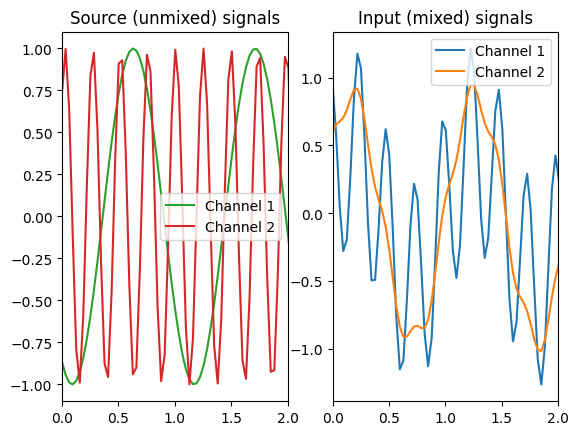

In [16]:
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(t, X1_unmixed[0, :, 0], color = 'C2', label = 'Channel 1')
plt.plot(t, X1_unmixed[0, :, 1], color = 'C3', label = 'Channel 2')
plt.xlim([0, 2])
plt.title('Source (unmixed) signals')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, X1[0, :, 0], label = 'Channel 1')
plt.plot(t, X1[0, :, 1], label = 'Channel 2')
plt.xlim([0, 2])
plt.title('Input (mixed) signals')
plt.legend()

# The CNN

We build a three-channel CNN to classify the mixed inputs based on $f_1$.

In [17]:
def build_model(input_shape):
    mInput = tf.keras.Input(input_shape)
    m = tf.keras.layers.Conv1D(filters = 32, 
                               kernel_size = 5,
                               padding = 'same',
                               activation = 'relu')(mInput)
    m = tf.keras.layers.Conv1D(filters = 32, 
                               kernel_size = 5,
                               padding = 'same',
                               activation = 'relu')(m)
    
    m = tf.keras.layers.Conv1D(filters = 32, 
                               kernel_size = 5,
                               padding = 'same',
                               activation = 'relu')(m)
    
    m = tf.keras.layers.GlobalAveragePooling1D()(m)
    m = tf.keras.layers.Dense(2, 
                              activation = 'linear')(m)

    model = tf.keras.models.Model(inputs = mInput,
                                  outputs = m)

    return model

class SoftmaxModel(tf.keras.models.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def call(self, x):
        return tf.nn.softmax(self.model(x))

In [18]:
model = build_model(input_shape = (256, 2))

In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model training

We now train the CNN to classify our times series samples. 

In [ ]:
n_epochs = 20

history = model.fit(
    x = X_train, 
    y = y_train,
    validation_data = (X_test, y_test),
    batch_size = 128,
    epochs = n_epochs,
    shuffle = True
)

In [21]:
softmaxModel = SoftmaxModel(model)

# Cross-domain saliency maps

We use cross-domain IG to generate saliency maps on two domains:
1. **Frequency domain** via the Fourier transform.  
2. **Independent components domain** via the Independent Component Analysis (ICA). 

Our library provides direct implementations of both domains. Extending our supported domains is easily via the ```Domain``` base class.

In [ ]:
n_ig_iterations = 500

x = X_test[y_test == 0][:1]
x_baseline = np.zeros_like(x)

fourierIG = FourierIG(softmaxModel, n_ig_iterations, output_channel = 0)
ig_frequency = fourierIG.run(x, x_baseline).numpy()

fastICA = FastICA(tol = 1e-9)
fastICA.fit(x[0])
print("FasICA converged in ", fastICA.n_iter_, " iterations.")

icaIG = ICAIG(softmaxModel, fastICA, n_ig_iterations, output_channel = 0)
ig_ica = icaIG.run(x, x_baseline).numpy()

# Plot results

We not plot the IG results.

## Frequency-domain IG
The IG attribution maps return maps for the two input channels in the frequency domain. The input sample we have used here is oscillating at $1.0 Hz$ and the saliency map highlights this frequency in both input channels. 

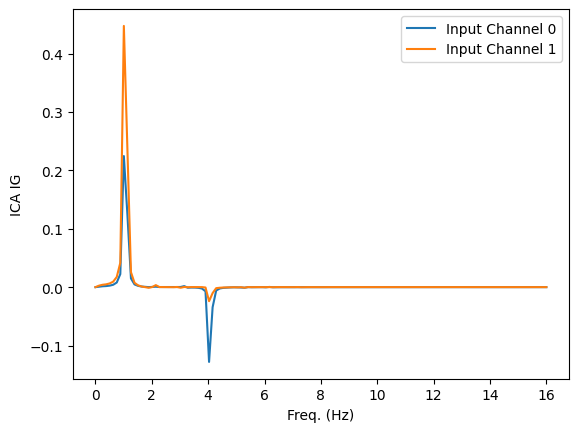

In [23]:
xf = np.linspace(0.0, 1.0/(2.0*(1/fs)), N_timepoints//2)
plt.figure()
plt.plot(xf, 2 * ig_frequency[0, :128], label = 'Input Channel 0')
plt.plot(xf, 2 * ig_frequency[1, :128], label = 'Input Channel 1')

plt.xlabel('Freq. (Hz)')
plt.ylabel('ICA IG')
plt.legend()

## ICA IG

We now demonstrate the IG in the basis defined by the independent components.

First we visualise the decomposition of the inputs into the ICA basis. Observe that through ICA we have successfully recovered the two original single-frequency oscillations.

In [24]:
x_decomp = icaIG.domain.forward_transform(x[0])

In [25]:
information_channel = np.argmax(ig_ica)

channel_colors = ['C3','C3']
channel_colors[information_channel] = 'C2'

Text(0.5, 1.0, 'Reconstructed Source (unmixed) channels.')

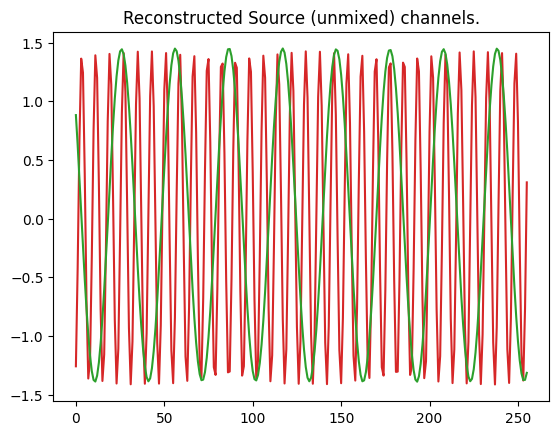

In [26]:
plt.figure()

for i in range(2):
    plt.plot(x_decomp[:, i], color = channel_colors[i])
plt.title('Reconstructed Source (unmixed) channels.')

We now visualise the ICA IG. The attributions highlight the $f_1 = 1.0Hz$ oscillation (slower oscillation - green) as the one tilting the model towards its final classification. Observe that these attributions exactly match the frequency ones. However, here, each channel is composed of only one single component oscillating at a single frequency. 

Text(0.5, 0, 'ICA IG')

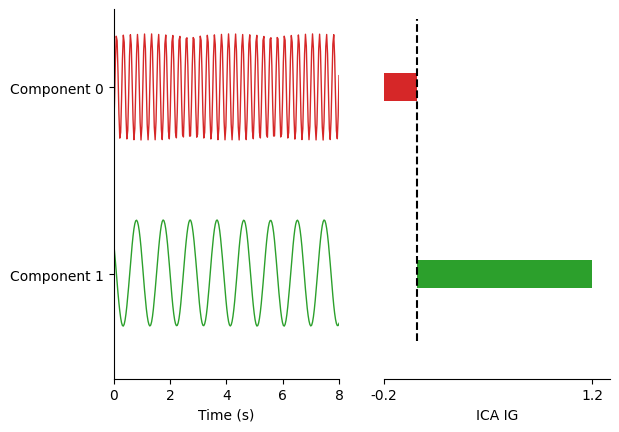

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2)

OFFSET = 5.0
scale = 1.0

for i in range(2):
    axes[0].plot(t, scale * x_decomp[..., i] - i * OFFSET, 
                 color=channel_colors[i], linewidth = 1.0,
                 alpha = 1.0)
    axes[0].set_xlim([t[0], t[-1]])
    axes[0].spines[['top', 'right']].set_visible(False)
    
    axes[1].barh(y = - i * OFFSET, width=ig_ica[i], 
                 height = 0.75, color=channel_colors[i])
    axes[1].set_xlim([0, max(ig_ica) * 1.1])
    axes[1].spines[['top', 'right', 'left']].set_visible(False)

ymin, ymax = axes[0].get_ylim()

axes[1].vlines(0.0, ymin, ymax, color = 'black', linestyles = 'dashed')

axes[1].set_xticks([ig_ica.min(), ig_ica.max()],
                   [f"{ig_ica.min():.1f}", f"{ig_ica.max():.1f}"])
axes[0].set_yticks([- i * OFFSET for i in range(2)], ['Component ' + str(i) for i in range(2)])
axes[1].set_yticks([])
    
margin_ratio = 1.15
axes[0].set_ylim([margin_ratio * ymin, margin_ratio * ymax])
axes[1].set_ylim([margin_ratio * ymin, margin_ratio * ymax])

axes[0].set_xlabel('Time (s)')
axes[1].set_xlabel('ICA IG')
